In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import sklearn

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

sys.path.append('./../')
from src.dataset import VehiclePredictorDataset
from src.utils import train_model, evaluate_model, get_model, visualize_model

/home/anip/miniconda3/envs/dl_proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GPU Check

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Config Variables

In [3]:
root_path = './../'
data_path = os.path.join(root_path, 'data')
dataset_path = os.path.join(data_path, 'VMMRdb')

# modify this line if you want to train a model on top 100/top 200/top 300 most common make_models
with open(os.path.join(data_path, 'make_model_most_common_100.pkl'), 'rb') as f:
    target_make_model_labels = pickle.load(f)

# load the dataset for some stats
vp_dataset = VehiclePredictorDataset(root_dir=dataset_path, target_make_model_labels=target_make_model_labels)
num_images = len(vp_dataset)
num_labels = len(vp_dataset.make_model_counts)
class_distribution = vp_dataset.make_model_counts
print(f"num_images: {num_images}")
print(f"num_labels: {num_labels}")

num_images: 184985
num_labels: 100


## Define the transforms
- Add other transforms here later, if needed. 
- Do we need any specific transforms for train and val?

In [4]:
def get_transform():
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return transform

## Instantiate the train, val and test dataloaders

In [5]:
train_split_ratio = 0.8
val_split_ratio = 0.1
test_split_ration = 0.1

# later see if you can have train-specific transforms
dataset = VehiclePredictorDataset(root_dir=dataset_path, target_make_model_labels=target_make_model_labels, transform=get_transform())

# split dataset in train and val set
dataset_len = len(dataset)
indices = torch.randperm(dataset_len).tolist()
train_split_index = int(train_split_ratio * dataset_len)
val_split_index = train_split_index + int(val_split_ratio * dataset_len)
train_dataset = torch.utils.data.Subset(dataset, indices[0:train_split_index])
val_dataset = torch.utils.data.Subset(dataset, indices[train_split_index:val_split_index])
test_dataset = torch.utils.data.Subset(dataset, indices[val_split_index:])

# define the dataloaders
dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

dataloader_val = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=1,
)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
)

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(val_dataset)
}

print(f'train: 0 to {train_split_index}\nval: {train_split_index} to {val_split_index}\ntest: {val_split_index} to {dataset_len-1}')
print(f'dataset_sizes : {dataset_sizes}')

train: 0 to 147988
val: 147988 to 166486
test: 166486 to 184984
dataset_sizes : {'train': 147988, 'val': 18498, 'test': 18498}


## Model config

In [6]:
# check https://pytorch.org/vision/0.8/models.html to experiment with other backbone model
backbone_model = 'resnet50'
num_epochs = 10

# get the model
model = get_model(num_labels, backbone_model).to(device)

# the reason for computing weights is to account for the class imbalance
weight_distribution = 1 / torch.tensor(list(class_distribution.values()))
weight_distribution = weight_distribution / weight_distribution.sum()
weight_distribution = weight_distribution.to(device)

# define the loss function
criterion = nn.CrossEntropyLoss(weight=weight_distribution)

# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# define the scheduler
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_info = {
    'backbone': backbone_model,
    'num_classes': f"{num_labels}classes",
    'num_epochs': f"{num_epochs}epochs",
}

## Train
- Uncomment this line if you want to train again. 
- The trained models are all stored in this [drive folder]( https://drive.google.com/drive/folders/1RXaKgStTFnVRaLvk-eIHEGhwvQp-y1-c?usp=sharing)

In [7]:
#train_model(model, model_info, dataset_sizes, dataloader_train, dataloader_val, criterion, optimizer, num_epochs=10)

## Evaluate on test set

In [8]:
# Load saved model
model_name = 'resnet18_100classes_10epochs.pth'
backbone_model = 'resnet18'
model = get_model(num_labels, backbone_model).to(device)
model.load_state_dict(torch.load(os.path.join(root_path, 'models', model_name)))

cm, cr = evaluate_model(model, dataset_sizes, dataloader_test)

# plot the CM
cm_pd = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_pd = pd.DataFrame(cm_pd, index=target_make_model_labels, columns=target_make_model_labels)
cr_pd = pd.DataFrame(cr).transpose()

100%|██████████| 18499/18499 [01:12<00:00, 254.42it/s]


Test Acc: 0.9497
Average time per image: 0.0039 seconds


- Confusion matrix

In [9]:
cm_pd

,honda_civic,honda_accord,ford_mustang,toyota_camry,chevrolet_silverado,nissan_altima,ford_f150,ford_explorer,chevrolet_impala,toyota_corolla,...,mercury_mountaineer,scion_tc,mercury_grandmarquis,chevrolet_equinox,lincoln_towncar,toyota_tundra,chevrolet_montecarlo,audi_a6,kia_optima,mitsubishi_lancer
honda_civic,0.980952,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000
honda_accord,0.000000,0.932432,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000
ford_mustang,0.000000,0.000000,0.953704,0.000000,0.0,0.0,0.0,0.000000,0.018519,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000
toyota_camry,0.000000,0.000000,0.000000,0.924138,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000
chevrolet_silverado,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
toyota_tundra,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.975,0.000000,0.000000,0.000000,0.000000
chevrolet_montecarlo,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.971154,0.000000,0.000000,0.000000
audi_a6,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.012987,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.948052,0.000000,0.000000
kia_optima,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.992806,0.000000


- Classification Report

In [10]:
cr_pd

,precision,recall,f1-score,support
honda_civic,1.000000,0.980952,0.990385,105.000000
honda_accord,0.985714,0.932432,0.958333,74.000000
ford_mustang,0.953704,0.953704,0.953704,108.000000
toyota_camry,0.656863,0.924138,0.767908,145.000000
chevrolet_silverado,1.000000,1.000000,1.000000,106.000000
...,...,...,...,...
kia_optima,0.992806,0.992806,0.992806,139.000000
mitsubishi_lancer,1.000000,0.990566,0.995261,106.000000
accuracy,0.949619,0.949619,0.949619,0.949619
macro avg,0.950610,0.961965,0.954570,18499.000000


- Save/Load the metrics

In [11]:
cm_pd.to_csv(os.path.join(root_path, 'results', 'baseline_methods', f"confusion_matrix_{model_name}.csv"), index=False)
cr_pd.to_csv(os.path.join(root_path, 'results', 'baseline_methods', f"classification_report_{model_name}.csv"), index=False)
#cm_pd_df = pd.read_csv(os.path.join(root_path, 'results', 'baseline_methods', f"confusion_matrix_{model_name}.csv"))
#cr_pd_df = pd.read_csv(os.path.join(root_path, 'results', 'baseline_methods', f"classification_report_{model_name}.csv"))

## Visually Inspect performance
- Load a target model to inpect

In [12]:
# Load saved model
model = get_model(num_labels, backbone_model).to(device)
model.load_state_dict(torch.load(os.path.join(root_path, 'models', model_name)))

<All keys matched successfully>

- Visualize for a few examples from the test set

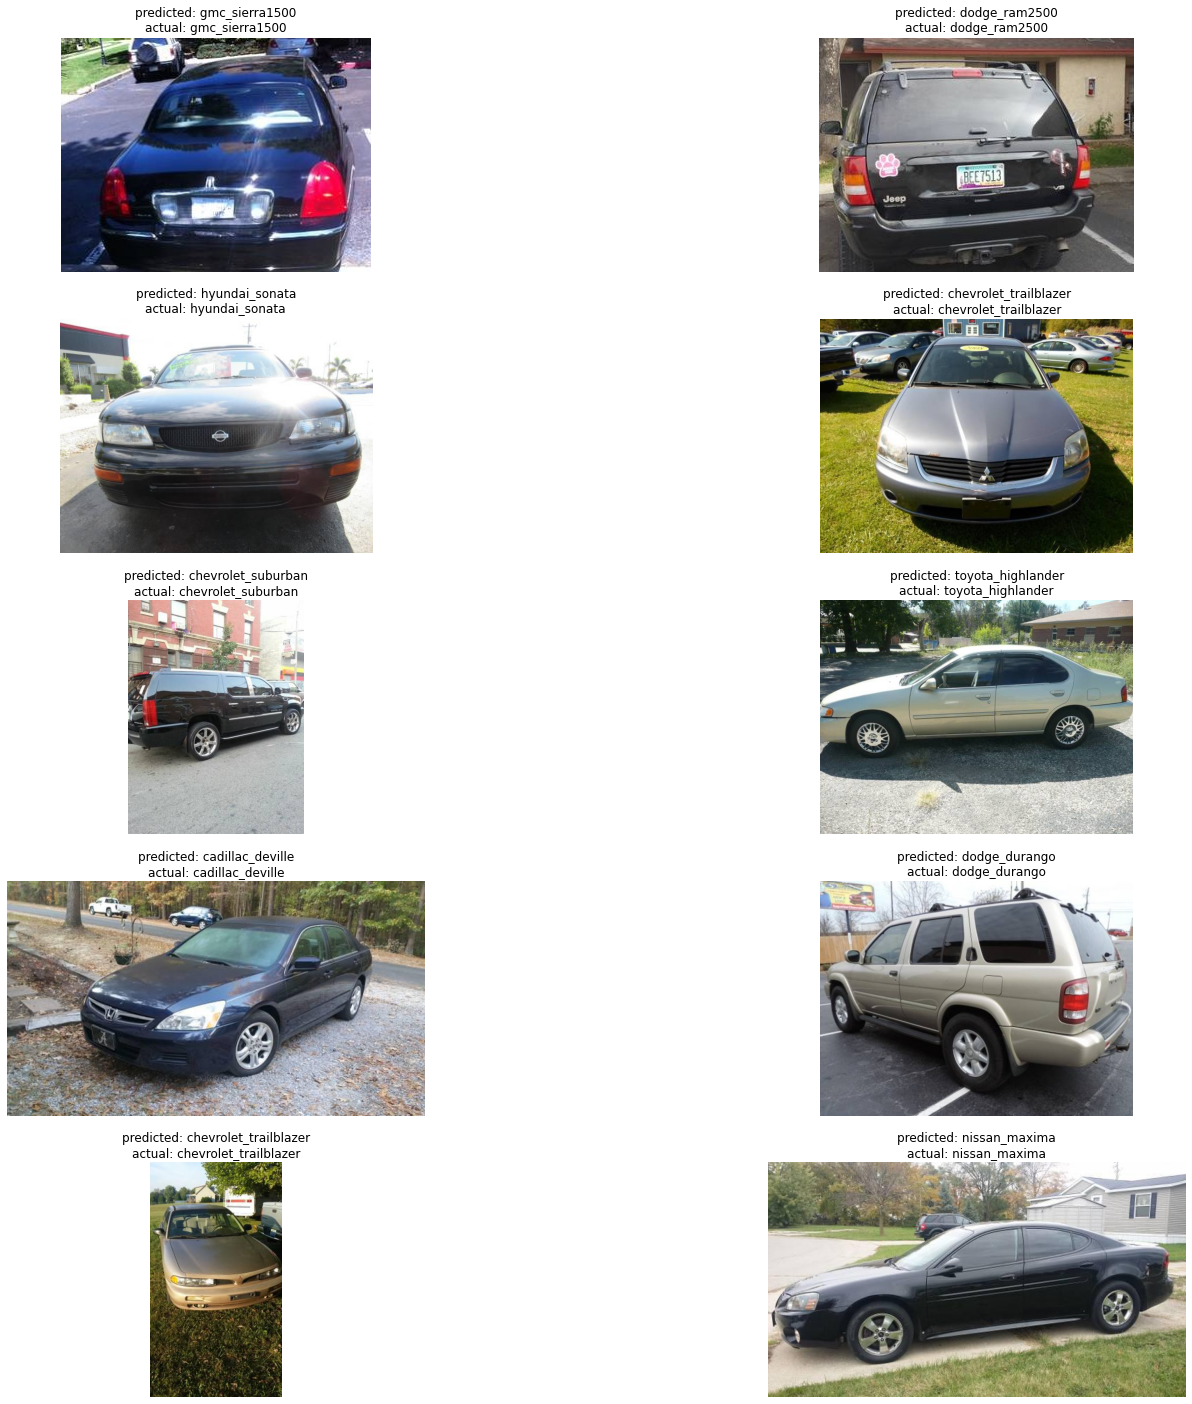

In [13]:
visualize_model(model, dataset, dataloader_test, num_images=10)